In [1]:
%load_ext autoreload
%autoreload 2 

In [ ]:
# If on colab
!git clone https://github.com/ieee8023/latentshift
!pip install -q -r latentshift/requirements.txt

In [2]:
import io
import os,sys
sys.path.insert(0,"latentshift")
sys.path.insert(0,"taming_transformers")
sys.path.insert(0,"latentshift/taming_transformers")

import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import classifiers
import autoencoders
import taming


In [3]:
# This is needed until the library is merged into captum
# !pip uninstall captum -y 
!git clone https://github.com/ieee8023/captum

In [4]:
sys.path.insert(0,"captum")
import captum

In [5]:
ae = autoencoders.Transformer(weights="faceshq", download=True)
model = classifiers.FaceAttribute(download=True)

In [6]:
x = PIL.Image.open("latentshift/sample_images/101.jpg").convert('RGB') 
x = torchvision.transforms.ToTensor()(x)[None,...]

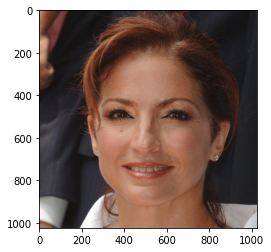

In [7]:
plt.imshow(x[0].permute(1, 2, 0).detach().numpy());

In [8]:
if torch.cuda.is_available():
    model = model.cuda()
    ae = ae.cuda()
    x = x.cuda()

In [9]:
model.targets

['blurry',
 'sideburns',
 'wearing_earrings',
 'bald',
 'goatee',
 'mustache',
 '5_o_clock_shadow',
 'arched_eyebrows',
 'no_beard',
 'heavy_makeup',
 'male',
 'wearing_lipstick',
 'black_hair',
 'high_cheekbones',
 'smiling',
 'mouth_slightly_open',
 'oval_face',
 'bushy_eyebrows',
 'attractive',
 'young',
 'gray_hair',
 'brown_hair',
 'blond_hair',
 'pale_skin',
 'chubby',
 'double_chin',
 'big_nose',
 'bags_under_eyes',
 'wearing_necklace',
 'wearing_necktie',
 'rosy_cheeks',
 'bangs',
 'wavy_hair',
 'straight_hair',
 'wearing_hat',
 'big_lips',
 'narrow_eyes',
 'pointy_nose',
 'receding_hairline',
 'eyeglasses']

In [10]:
target = model.targets.index("smiling")

Shift: 0 , Prediction: [0.9271998]
Shift: -10.0 , Prediction: [0.88699067]
Shift: -21.0 , Prediction: [0.8257798]
Shift: -34.0 , Prediction: [0.734204]
Shift: -48.0 , Prediction: [0.58928424]
Shift: -63.0 , Prediction: [0.40850517]
Shift: -80.0 , Prediction: [0.24100243]
Shift: -98.0 , Prediction: [0.14709815]
Shift: -118.0 , Prediction: [0.09567073]
Selected bounds:  -118.0 0
Shift: -106.2 , Prediction: [0.12366492]
Shift: -94.4 , Prediction: [0.15986925]
Shift: -82.60000000000001 , Prediction: [0.22005603]
Shift: -70.80000000000001 , Prediction: [0.32373503]
Shift: -59.000000000000014 , Prediction: [0.45406553]
Shift: -47.20000000000002 , Prediction: [0.59868765]
Shift: -35.40000000000002 , Prediction: [0.723075]
Shift: -23.600000000000023 , Prediction: [0.80777365]
Shift: -11.800000000000026 , Prediction: [0.87792706]


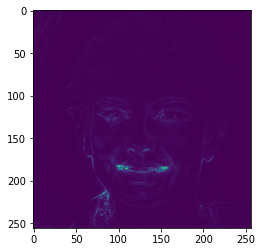

In [11]:
attr = captum.attr.LatentShift(model, ae)
output = attr.attribute(x, target=target)
plt.imshow(output['heatmap']);

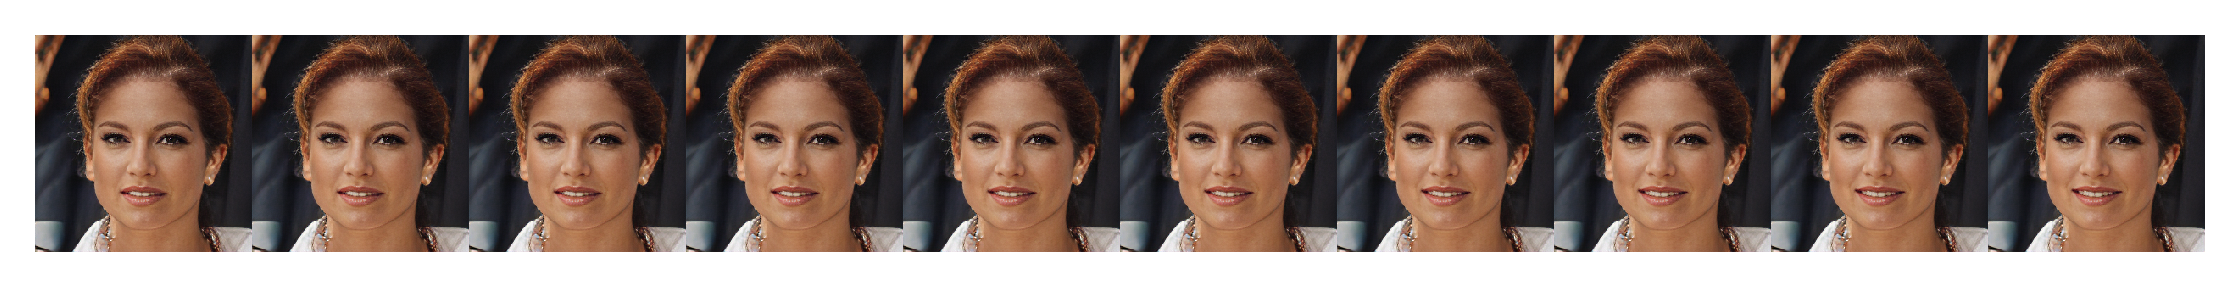

In [12]:
images_f = [h.transpose(0, 2, 3, 1) for h in output["generated_images"]]
dimgs = np.concatenate(images_f)
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none');
plt.axis('off');

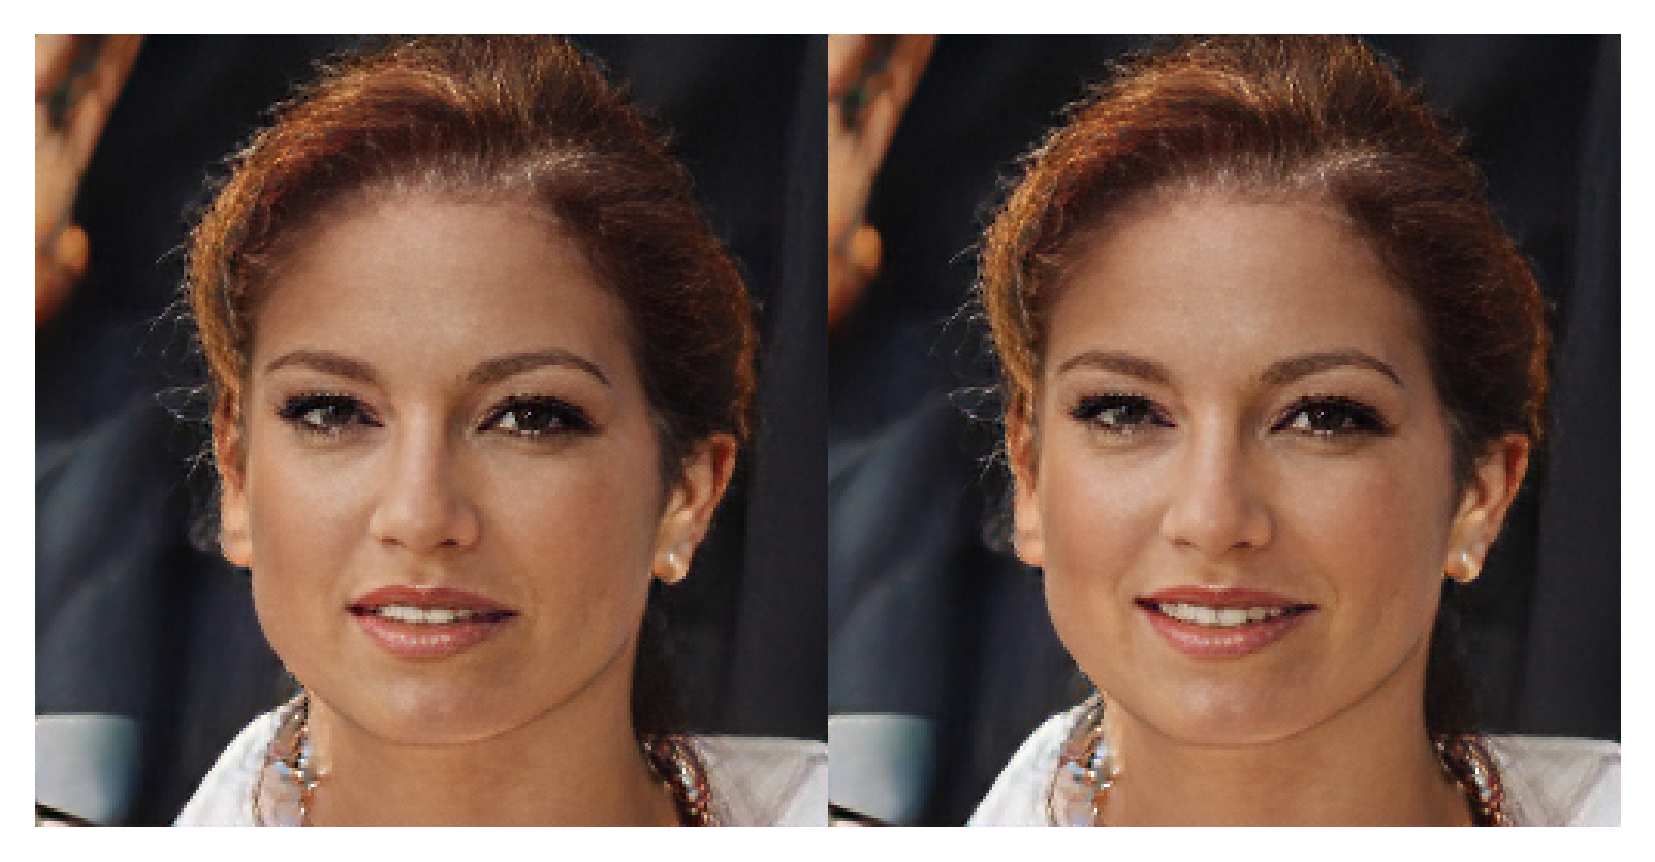

In [13]:
dimgs = np.concatenate([images_f[0], images_f[-1]])
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none');
plt.axis('off');

In [14]:
attr.generate_video(output, "test")

ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:256 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=-1.0 Lsize=      15kB time=00:00:00.76 bitrate= 156.7kbits/s speed=13.2x    
